In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-10-24 04:24:46  33.93911   
1   NaN    NaN            NaN        Albania  2020-10-24 04:24:46  41.15330   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953    40687.0  1507.0    34010.0  5170.0  Afghanistan   
1  20.168300    18556.0   469.0    10466.0  7621.0      Albania   

   Incidence_Rate  Case-Fatality_Ratio       Date  
0      104.517683             3.703886 2020-10-23  
1      644.798110             2.527484 2020-10-23

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    7491
unique                    227
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-10-23 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     227
unique                    227
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-10-23 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     247
unique                    247
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-10-23 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State Country_Region  \
2432  32029.0                Storey                 Nevada             US   
66        NaN                   NaN       British Columbia         Canada   
159       NaN                   NaN                  Sucre       Colombia   
66        NaN                   NaN       British Columbia         Canada   
201       NaN                   NaN                    NaN         France   
...       ...                   ...                    ...            ...   
3186      NaN                   NaN   Prince Edward Island         Canada   
3187      NaN                   NaN  Northwest Territories         Canada   
3188      NaN                   NaN       Diamond Princess         Canada   
3415  11001.0  District of Columbia   District of Columbia             US   
3416  53023.0       Garfield County             Washington             US   

              Last_Update        Lat       Long_  Confirmed   Deaths  \
2432  2020-10-24 04:24:46  39.448755 -119.525021       21.0      0.0   
66    2020-10-23 04:24:46  53.726700 -127.647600    12057.0    256.0   
159   2020-10-23 04:24:46   8.814000  -74.723300    15205.0    606.0   
66    2020-10-22 04:24:27  53.726700 -127.647600    12057.0    256.0   
201   2020-10-21 04:24:14  46.227600    2.213700   939147.0  33636.0   
...                   ...        ...         ...        ...      ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0      0.0   
3187        3/22/20 23:48        NaN         NaN        1.0      0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0      1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0      2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0      2.0   

      Recovered    Active                                  Combined_Key  \
2432        0.0       0.0                            Storey, Nevada, US   
66       4931.0    1920.0                      British Columbia, Canada   
159     14125.0     470.0                               Sucre, Colombia   
66       4931.0    1766.0                      British Columbia, Canada   
201     87138.0  818185.0                                        France   
...         ...       ...                                           ...   
3186        0.0       0.0                  Prince Edward Island, Canada   
3187        0.0       0.0                 Northwest Territories, Canada   
3188        0.0       0.0                      Diamond Princess, Canada   
3415        0.0       0.0  District of Columbia,District of Columbia,US   
3416        0.0       0.0                 Garfield County,Washington,US   

      Incidence_Rate  Case-Fatality_Ratio       Date  
2432        0.000000             0.000000 2020-10-23  
66        241.267859             2.123248 2020-10-22  
159      1668.981934             3.985531 2020-10-22  
66        235.906785             2.123248 2020-10-21  
201      1438.470171             3.581548 2020-10-20  
...              ...                  ...        ...  
3186             NaN                  NaN 2020-03-22  
3187             NaN                  NaN 2020-03-22  
3188             NaN                  NaN 2020-03-22  
3415             NaN                  NaN 2020-03-22  
3416             NaN                  NaN 2020-03-22  

[44570 rows x 15 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44068 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            44068 non-null  float64
 1   Deaths               44068 non-null  float64
 2   Recovered            44068 non-null  float64
 3   Active               44068 non-null  float64
 4   Incidence_Rate       44068 non-null  float64
 5   Case-Fatality_Ratio  44068 non-null  float64
dtypes: float64(6)
memory usage: 2.2+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'India', 'Brazil', 'Russia', 'France', 'Argentina', 'Spain',
       'Colombia', 'Mexico', 'Peru', 'United Kingdom', 'South Africa', 'Iran',
       'Chile', 'Italy', 'Iraq', 'Bangladesh', 'Indonesia', 'Philippines',
       'Turkey', 'Saudi Arabia', 'Ukraine', 'Pakistan', 'Israel', 'Belgium',
       'Germany', 'Netherlands', 'Czechia', 'Poland', 'Canada', 'Romania',
       'Morocco', 'Ecuador', 'Nepal', 'Bolivia', 'Qatar', 'Panama',
       'Dominican Republic', 'United Arab Emirates', 'Kuwait', 'Portugal',
       'Oman', 'Sweden', 'Kazakhstan', 'Egypt', 'Guatemala', 'Switzerland',
       'Costa Rica', 'Japan', 'Ethiopia'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))
print()
print('\n'.join(c for c in population.index if 'Venezuela' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)

Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12261 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-10-23 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            12261 non-null  float64
 1   Deaths               12261 non-null  float64
 2   Recovered            12261 non-null  float64
 3   Active               12261 non-null  float64
 4   Incidence_Rate       12261 non-null  float64
 5   Case-Fatality_Ratio  12261 non-null  float64
 6   Confirmed_per_100k   12261 non-null  float64
 7   Deaths_per_100k      12261 non-null  float64
 8   Recovered_per_100k   12261 non-null  float64
 9   Active_per_100k      12261 non-null  float64
dtypes: float64(10)
memory usage: 1009.9+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Argentina      2020-03-03             0.0                  0.0   
               2020-03-04             0.0                  0.0   
               2020-03-05             0.0                  0.0   
               2020-03-06             0.0                  0.0   
               2020-03-07             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03            0.002233              0.0   
               2020-03-04            0.002233              0.0   
               2020-03-05            0.002233              0.0   
               2020-03-06            0.004466              0.0   
               2020-03-07            0.017865              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 0.0         0.002233  
               2020-03-04                 0.0         0.002233  
               2020-03-05                 0.0         0.002233  
               2020-03-06                 0.0         0.004466  
               2020-03-07                 0.0         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


Confirmed    Deaths  Recovered     Active  \
Country_Region                                                    
Argentina             1069368.0   28338.0   866695.0   174335.0   
Bangladesh             396413.0    5761.0   312065.0   115779.0   
Belgium                287700.0   10658.0    22517.0   254525.0   
Bolivia                140612.0    8608.0   107633.0    60928.0   
Brazil                5353656.0  156471.0  4526393.0   670792.0   
Canada                 214519.0    9940.0   180626.0    36033.0   
Chile                  498906.0   13844.0   471166.0    95631.0   
Colombia               998942.0   29802.0   901652.0   169326.0   
Costa Rica             101826.0    1265.0    61662.0    43461.0   
Czechia                238323.0    1971.0    91651.0   144701.0   
Dominican Republic     122873.0    2212.0   100920.0    35057.0   
Ecuador                158270.0   12528.0   134187.0    44283.0   
Egypt                  106230.0    6176.0    98713.0    55230.0   
Ethiopia                92229.0    1400.0    46118.0    45481.0   
France                1084659.0   34536.0   113636.0   936487.0   
Germany                279223.0    9203.0   208115.0    72864.0   
Guatemala              103902.0    3594.0    93341.0    27377.0   
India                 7761312.0  117306.0  6948497.0  1017754.0   
Indonesia              381910.0   13077.0   305100.0    66578.0   
Iran                   556891.0   31985.0   446685.0    78221.0   
Iraq                   445949.0   10513.0   375188.0    63157.0   
Israel                 308840.0    2329.0   290130.0    72400.0   
Italy                  484869.0   37059.0   261808.0   186002.0   
Japan                   95868.0    1706.0    87600.0    17240.0   
Kazakhstan             110250.0    1796.0   105566.0    34497.0   
Kuwait                 120232.0     740.0   111440.0    15831.0   
Mexico                 880775.0   88312.0   740934.0    53350.0   
Morocco                190416.0    3205.0   157175.0    30036.0   
Nepal                  153008.0     829.0   105488.0    46691.0   
Netherlands            278546.0    7026.0     5517.0   266003.0   
Oman                   111837.0    1147.0    97949.0    23276.0   
Pakistan               327063.0    6727.0   310101.0   108642.0   
Panama                 127866.0    2622.0   103985.0    25549.0   
Peru                   879876.0   33984.0   796719.0   168092.0   
Philippines            365799.0    6915.0   312691.0    83109.0   
Poland                 228318.0    4172.0   105092.0   119054.0   
Portugal               112440.0    2276.0    65880.0    44284.0   
Qatar                  130711.0     229.0   127599.0    35634.0   
Romania                201032.0    6245.0   144429.0    61134.0   
Russia                1471000.0   25353.0  1113736.0   331911.0   
Saudi Arabia           344157.0    5264.0   330578.0    63026.0   
South Africa           712412.0   18891.0   643523.0   173590.0   
Spain                 1046132.0   34752.0   150376.0   861004.0   
Sweden                 110594.0    5933.0     4971.0   104661.0   
Switzerland            103653.0    2145.0    55800.0    45786.0   
Turkey                 357693.0    9658.0   311520.0    80808.0   
US                    8491459.0  223975.0  3375427.0  4892057.0   
Ukraine                340042.0    6336.0   143093.0   190613.0   
United Arab Emirates   122273.0     475.0   115068.0    17173.0   
United Kingdom         834010.0   46791.0     2657.0   786692.0   

                      Incidence_Rate  Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region                                                                  
Argentina               2.366079e+03             3.372463         2388.012240   
Bangladesh              2.407034e+02             1.462851          243.129288   
Belgium                 2.482395e+03            16.247214         2493.213208   
Bolivia                 1.204589e+03             6.121810         1221.321586   
Brazil                  9.237139e+04           108.

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                           
US                    8491459.0  223975.0
India                 7761312.0  117306.0
Brazil                5353656.0  156471.0
Russia                1471000.0   25353.0
France                1084659.0   34536.0
Argentina             1069368.0   28338.0
Spain                 1046132.0   34752.0
Colombia               998942.0   29802.0
Mexico                 880775.0   88312.0
Peru                   879876.0   33984.0
United Kingdom         834010.0   46791.0
South Africa           712412.0   18891.0
Iran                   556891.0   31985.0
Chile                  498906.0   13844.0
Italy                  484869.0   37059.0
Iraq                   445949.0   10513.0
Bangladesh             396413.0    5761.0
Indonesia              381910.0   13077.0
Philippines            365799.0    6915.0
Turkey                 357693.0    9658.0
Saudi Arabia           344157.0    5264.0
Ukraine                340042.0    6336.0
Pakistan               327063.0    6727.0
Israel                 308840.0    2329.0
Belgium                287700.0   10658.0
Germany                279223.0    9203.0
Netherlands            278546.0    7026.0
Czechia                238323.0    1971.0
Poland                 228318.0    4172.0
Canada                 214519.0    9940.0
Romania                201032.0    6245.0
Morocco                190416.0    3205.0
Ecuador                158270.0   12528.0
Nepal                  153008.0     829.0
Bolivia                140612.0    8608.0
Qatar                  130711.0     229.0
Panama                 127866.0    2622.0
Dominican Republic     122873.0    2212.0
United Arab Emirates   122273.0     475.0
Kuwait                 120232.0     740.0
Portugal               112440.0    2276.0
Oman                   111837.0    1147.0
Sweden                 110594.0    5933.0
Kazakhstan             110250.0    1796.0
Egypt                  106230.0    6176.0
Guatemala              103902.0    3594.0
Switzerland            103653.0    2145.0
Costa Rica             101826.0    1265.0
Japan                   95868.0    1706.0
Ethiopia                92229.0    1400.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k  Confirmed    Deaths
Country_Region                                               
Qatar                        4615.385702   130711.0     229.0
Israel                       3625.149409   308840.0    2329.0
Panama                       3011.134032   127866.0    2622.0
Kuwait                       2857.851187   120232.0     740.0
Peru                         2706.439546   879876.0   33984.0
Chile                        2632.466645   498906.0   13844.0
US                           2580.481407  8491459.0  223975.0
Brazil                       2536.682398  5353656.0  156471.0
Belgium                      2493.213208   287700.0   10658.0
Argentina                    2388.012240  1069368.0   28338.0
Oman                         2247.983514   111837.0    1147.0
Spain                        2238.348374  1046132.0   34752.0
Czechia                      2229.565451   238323.0    1971.0
Costa Rica                   2017.330746   101826.0    1265.0
Colombia                     1984.412104   998942.0   29802.0
France                       1665.382281  1084659.0   34536.0
Netherlands                  1629.198082   278546.0    7026.0
United Arab Emirates         1251.447466   122273.0     475.0
United Kingdom               1235.018527   834010.0   46791.0
Bolivia                      1221.321586   140612.0    8608.0
South Africa                 1216.586550   712412.0   18891.0
Switzerland                  1206.479392   103653.0    2145.0
Dominican Republic           1144.180017   122873.0    2212.0
Iraq                         1134.447707   445949.0   10513.0
Sweden                       1101.929967   110594.0    5933.0
Portugal                     1099.531027   112440.0    2276.0
Romania                      1038.144015   201032.0    6245.0
Russia                       1008.416542  1471000.0   25353.0
Saudi Arabia                 1004.294640   344157.0    5264.0
Ecuador                       910.976889   158270.0   12528.0
Italy                         800.773350   484869.0   37059.0
Ukraine                       772.934399   340042.0    6336.0
Mexico                        690.394942   880775.0   88312.0
Iran                          671.649804   556891.0   31985.0
Poland                        602.616607   228318.0    4172.0
Kazakhstan                    594.293873   110250.0    1796.0
Guatemala                     590.974273   103902.0    3594.0
Canada                        573.410981   214519.0    9940.0
India                         568.004329  7761312.0  117306.0
Nepal                         534.830033   153008.0     829.0
Morocco                       522.091527   190416.0    3205.0
Turkey                        428.736288   357693.0    9658.0
Philippines                   338.337430   365799.0    6915.0
Germany                       334.330551   279223.0    9203.0
Bangladesh                    243.129288   396413.0    5761.0
Pakistan                      151.022797   327063.0    6727.0
Indonesia                     141.121182   381910.0   13077.0
Egypt                         105.819341   106230.0    6176.0
Ethiopia                       82.289479    92229.0    1400.0
Japan                          75.569741    95868.0    1706.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                 
Mexico                 880775.0   88312.0              0.100266
Ecuador                158270.0   12528.0              0.079156
Italy                  484869.0   37059.0              0.076431
Bolivia                140612.0    8608.0              0.061218
Egypt                  106230.0    6176.0              0.058138
Iran                   556891.0   31985.0              0.057435
United Kingdom         834010.0   46791.0              0.056104
Sweden                 110594.0    5933.0              0.053647
Canada                 214519.0    9940.0              0.046336
Peru                   879876.0   33984.0              0.038624
Belgium                287700.0   10658.0              0.037046
Guatemala              103902.0    3594.0              0.034590
Indonesia              381910.0   13077.0              0.034241
Spain                 1046132.0   34752.0              0.033220
Germany                279223.0    9203.0              0.032959
France                1084659.0   34536.0              0.031840
Romania                201032.0    6245.0              0.031065
Colombia               998942.0   29802.0              0.029834
Brazil                5353656.0  156471.0              0.029227
Chile                  498906.0   13844.0              0.027749
Turkey                 357693.0    9658.0              0.027001
South Africa           712412.0   18891.0              0.026517
Argentina             1069368.0   28338.0              0.026500
US                    8491459.0  223975.0              0.026377
Netherlands            278546.0    7026.0              0.025224
Iraq                   445949.0   10513.0              0.023574
Switzerland            103653.0    2145.0              0.020694
Pakistan               327063.0    6727.0              0.020568
Panama                 127866.0    2622.0              0.020506
Portugal               112440.0    2276.0              0.020242
Philippines            365799.0    6915.0              0.018904
Ukraine                340042.0    6336.0              0.018633
Poland                 228318.0    4172.0              0.018273
Dominican Republic     122873.0    2212.0              0.018002
Japan                   95868.0    1706.0              0.017795
Russia                1471000.0   25353.0              0.017235
Morocco                190416.0    3205.0              0.016832
Kazakhstan             110250.0    1796.0              0.016290
Saudi Arabia           344157.0    5264.0              0.015295
Ethiopia                92229.0    1400.0              0.015180
India                 7761312.0  117306.0              0.015114
Bangladesh             396413.0    5761.0              0.014533
Costa Rica             101826.0    1265.0              0.012423
Oman                   111837.0    1147.0              0.010256
Czechia                238323.0    1971.0              0.008270
Israel                 308840.0    2329.0              0.007541
Kuwait                 120232.0     740.0              0.006155
Nepal                  153008.0     829.0              0.005418
United Arab Emirates   122273.0     475.0              0.003885
Qatar                  130711.0     229.0              0.001752

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

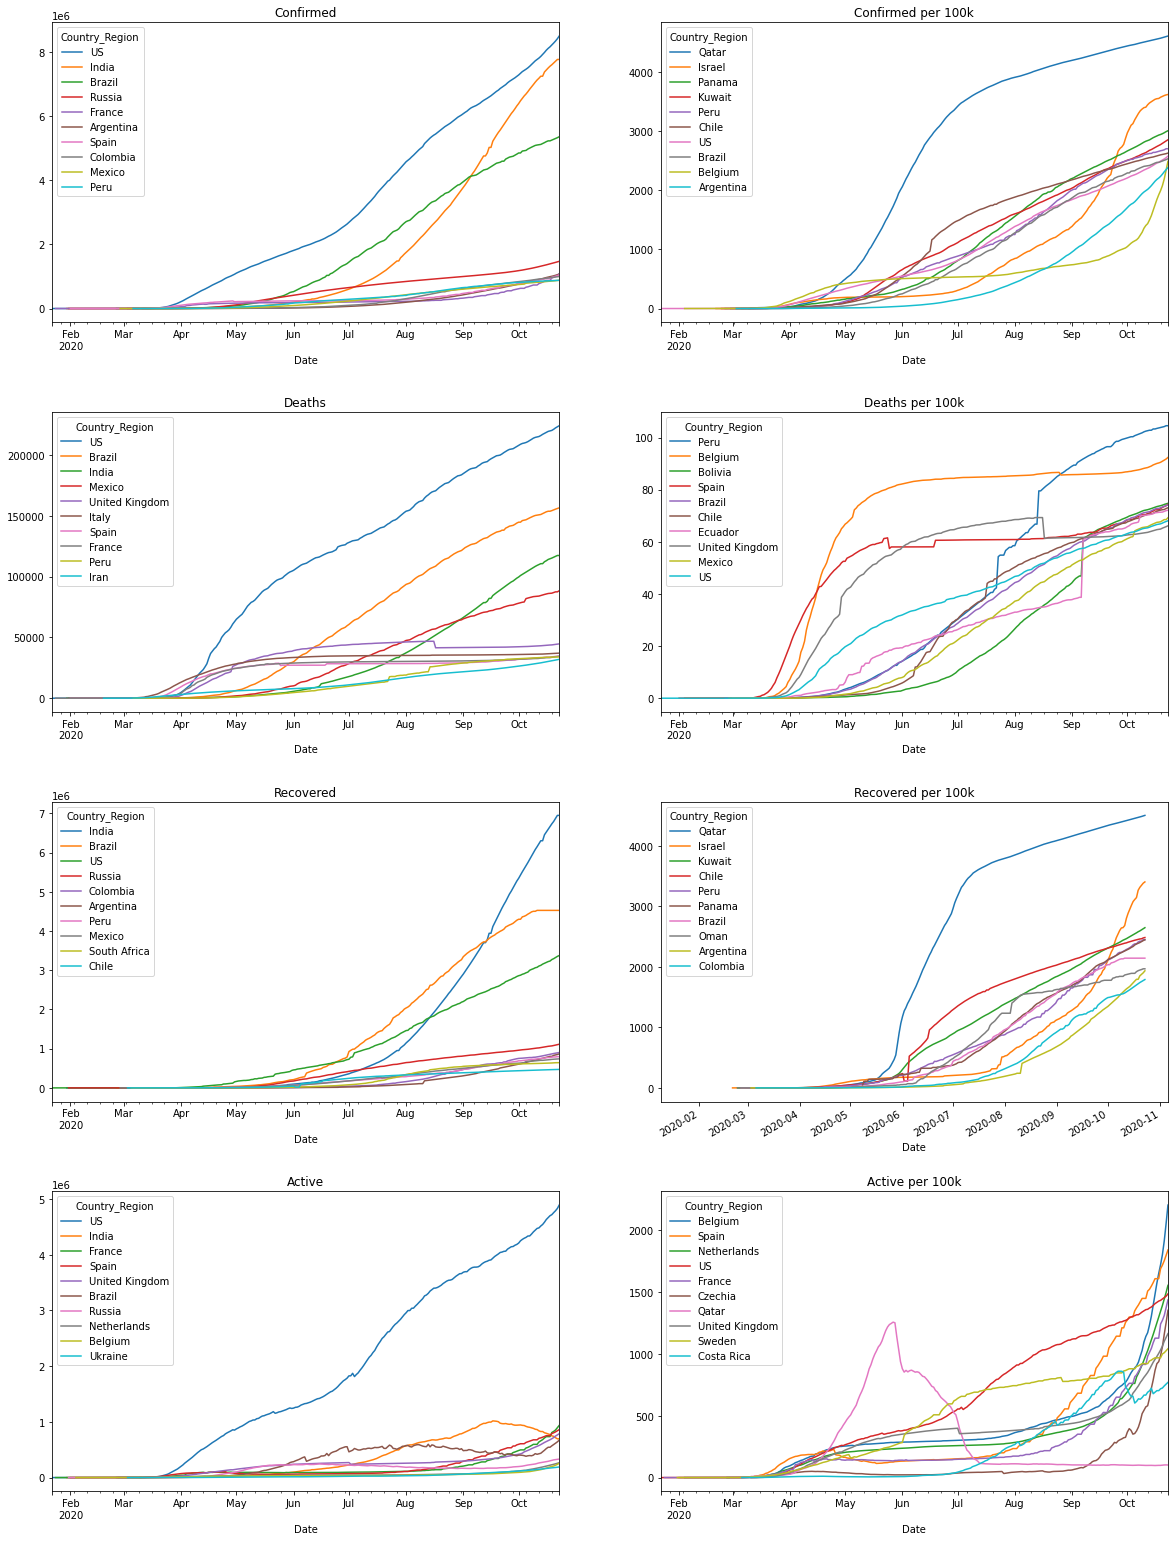

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

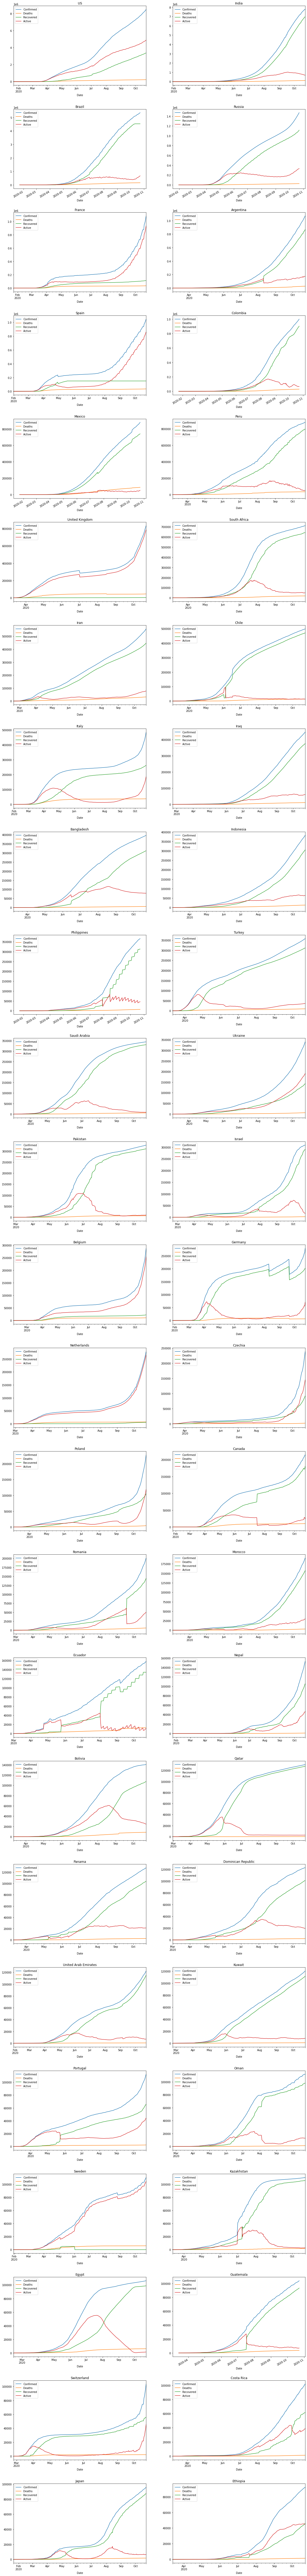

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-10-19    17332.6   114.2       12.4   
                              2020-10-20    17806.4   134.8       13.0   
                              2020-10-21    20016.4   145.8       14.2   
                              2020-10-22    21030.6   153.6       16.0   
                              2020-10-23    21743.6   185.0       13.6   

                                           Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                      
Argentina      Argentina      2020-03-03      NaN                 NaN   
                              2020-03-04      NaN                 NaN   
                              2020-03-05      NaN                 NaN   
                              2020-03-06      NaN                 NaN   
                              2020-03-07      NaN                 NaN   
...                                           ...                 ...   
United Kingdom United Kingdom 2020-10-19  17206.0           25.666457   
                              2020-10-20  17658.6           26.368070   
                              2020-10-21  19856.4           29.640682   
                              2020-10-22  20861.0           31.142529   
                              2020-10-23  21545.0           32.198354   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03              NaN                 NaN   
                              2020-03-04              NaN                 NaN   
                              2020-03-05              NaN                 NaN   
                              2020-03-06              NaN                 NaN   
                              2020-03-07              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-10-19         0.169110            0.018362   
                              2020-10-20         0.199615            0.019251   
                              2020-10-21         0.215904            0.021028   
                              2020-10-22         0.227454            0.023693   
                              2020-10-23         0.273952            0.020139   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Argentina      Argentina      2020-03-03              NaN  
                              2020-03-04              NaN  
                              2020-03-05              NaN  
                              2020-03-06              NaN  
                              2020-03-07              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-10-19        25.478986  
                              2020-10-20        26.149205  
                              2020-10-21        29.403750  
                              2020-10-22        30.891382  
                              2020-10-23        31.904263  

[12261 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-03-03        NaN     NaN        NaN      NaN   
               2020-03-04        NaN     NaN        NaN      NaN   
               2020-03-05        NaN     NaN        NaN      NaN   
               2020-03-06        NaN     NaN        NaN      NaN   
               2020-03-07        NaN     NaN        NaN      NaN   
...                              ...     ...        ...      ...   
United Kingdom 2020-10-19    17332.6   114.2       12.4  17206.0   
               2020-10-20    17806.4   134.8       13.0  17658.6   
               2020-10-21    20016.4   145.8       14.2  19856.4   
               2020-10-22    21030.6   153.6       16.0  20861.0   
               2020-10-23    21743.6   185.0       13.6  21545.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-10-19           25.666457         0.169110   
               2020-10-20           26.368070         0.199615   
               2020-10-21           29.640682         0.215904   
               2020-10-22           31.142529         0.227454   
               2020-10-23           32.198354         0.273952   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-10-19            0.018362        25.478986  
               2020-10-20            0.019251        26.149205  
               2020-10-21            0.021028        29.403750  
               2020-10-22            0.023693        30.891382  
               2020-10-23            0.020139        31.904263  

[12261 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

235

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-10-19    14139.0   359.0    10563.8  3216.2   
               2020-10-20    13987.2   351.6    12957.6   678.0   
               2020-10-21    14343.2   359.2    12403.8  1580.2   
               2020-10-22    14906.2   370.0    12136.0  2400.2   
               2020-10-23    15937.6   414.2    12546.0  2977.4   
Bangladesh     2020-03-08        NaN     NaN        NaN     NaN   
               2020-03-09        NaN     NaN        NaN     NaN   
               2020-03-10        NaN     NaN        NaN     NaN   
               2020-03-11        NaN     NaN        NaN     NaN   
               2020-03-12        NaN     NaN        NaN     NaN   
               2020-03-13        0.0     0.0        0.0     0.0   
               2020-03-14        0.0     0.0        0.0     0.0   
               2020-03-15        0.4     0.0        0.0     0.4   
               2020-03-16        1.0     0.0        0.4     0.6   
               2020-03-17        1.4     0.0        0.6     0.8   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-10-19           31.573888         0.801685   
               2020-10-20           31.234902         0.785160   
               2020-10-21           32.029888         0.802132   
               2020-10-22           33.287127         0.826249   
               2020-10-23           35.590352         0.924953   
Bangladesh     2020-03-08                 NaN              NaN   
               2020-03-09                 NaN              NaN   
               2020-03-10                 NaN              NaN   
               2020-03-11                 NaN              NaN   
               2020-03-12                 NaN              NaN   
               2020-03-13            0.000000         0.000000   
               2020-03-14            0.000000         0.000000   
               2020-03-15            0.000245         0.000000   
               2020-03-16            0.000613         0.000000   
               2020-03-17            0.000859         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-10-19           23.590087         7.182116  
               2020-10-20           28.935696         1.514046  
               2020-10-21           27.699002         3.528754  
               2020-10-22           27.100976         5.359901  
               2020-10-23           28.016550         6.648850  
Bangladesh     2020-03-08                 NaN              NaN  
               2020-03-09                 NaN              NaN  
               2020-03-10                 NaN              NaN  
               2020-03-11                 NaN              NaN  
               2020-03-12                 NaN              NaN  
               2020-03-13            0.000000         0.000000  
               2020-03-14            0.000000         0.000000  
               2020-03-15            0.000000         0.000245  
               2020-03-16            0.000245         0.000368  
               2020-03-17            0.000368         0.000491

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112        22.578936   
               2020-05-30           10.692112        24.336391   
               2020-05-31           11.915854        24.510573   
               2020-06-01           12.328979        25.318957   
               2020-06-02           12.748803        26.888831   
               2020-06-03           13.166394        28.559194   
               2020-06-04           13.383005        30.361311   
               2020-06-05           13.595150        31.971381   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Argentina      2020-05-22           516.2         12.0            98.6   
               2020-05-23           596.4         12.6           181.0   
               2020-05-24           653.4         11.8           172.0   
               2020-05-25           669.0         12.8           213.2   
               2020-05-26           659.4         13.6           227.0   
               2020-05-27           656.8         13.4           257.4   
               2020-05-28       

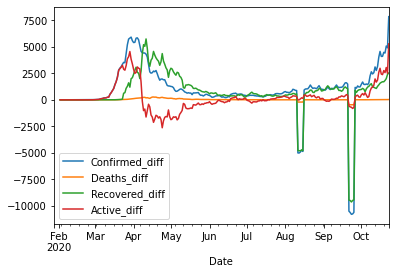

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

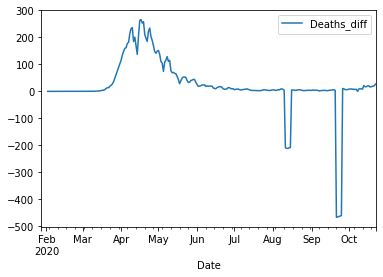

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

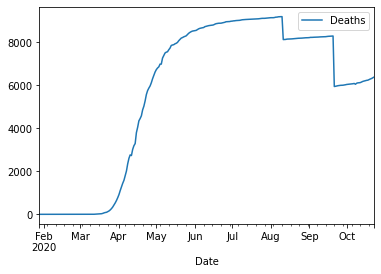

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

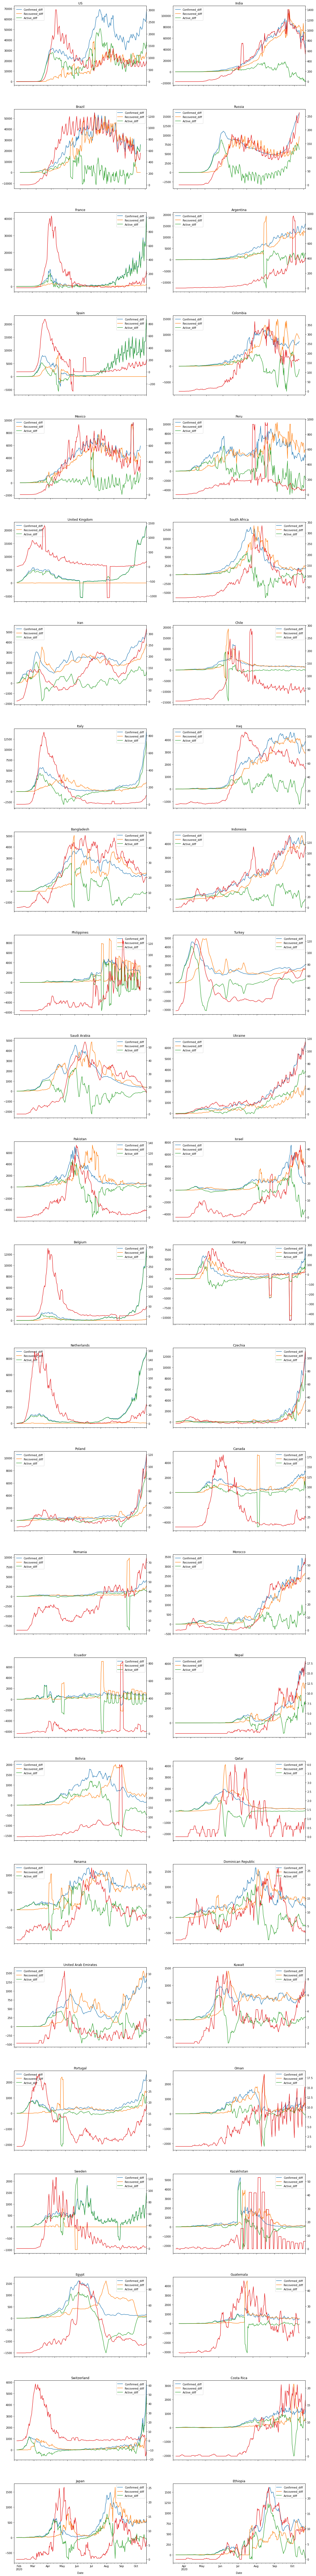

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50